In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [39]:
res1 = pd.read_csv('../results/runs/052623/results_xgb_folfox_OS_comb_052623.csv', index_col=0)
res1.head()

,fold,val_auroc_mean,val_auroc_ci,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci
0,0,0.777612,0.6854916816503743-0.8697315239657742,0.794643,0.7703711113951469-0.8189146028905675,0.765503,0.740046726252081-0.7909601071737741
1,1,0.770019,0.7175307734505394-0.8225067433061828,0.802474,0.778552166683152-0.8263951248313036,0.800918,0.7769262311621081-0.8249106008939149
2,2,0.786206,0.7015926265171472-0.8708203218620177,0.796263,0.7720630132534749-0.8204638628554906,0.771958,0.7467484368889246-0.7971674572836946
3,3,0.785038,0.7371987116371631-0.8328770909647017,0.777328,0.7522852747843285-0.8023705956610157,0.766976,0.7415289132581924-0.7924229289578459
4,4,0.789119,0.7178330046737855-0.8604045432189349,0.745675,0.7194625077928946-0.7718882467157547,0.729521,0.702782402873017-0.756258703418702


In [40]:
#get the mean of 'val_auroc_mean'
val_auroc_mean = res1['val_auroc_mean'].mean()
#get the ci of 'val_auroc_mean'
val_auroc_ci = res1['val_auroc_mean'].std()
#get the mean of 'test_auroc_mean'
test_auroc_mean = res1['test_auroc_mean'].mean()
#get the ci of 'test_auroc_mean'
test_auroc_ci = res1['test_auroc_mean'].std()
test_auprc_mean = res1['test_auprc_mean'].mean()
test_auprc_ci = res1['test_auprc_mean'].std()

In [41]:
res_df = pd.DataFrame({'model':'rf', 'val_auroc_mean': [val_auroc_mean], 'val_auroc_ci': [val_auroc_ci], 'test_auroc_mean': [test_auroc_mean], 'test_auroc_ci': [test_auroc_ci], 'test_auprc_mean': [test_auprc_mean], 'test_auprc_ci': [test_auprc_ci]})
res_df

,model,val_auroc_mean,val_auroc_ci,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci
0,rf,0.781599,0.00774,0.783277,0.022998,0.766975,0.025407


In [42]:
today_str = '060923'
model_types = ['rf', 'xgb']
drugs = ['folfox', 'egfr', 'vegf', 'reg']
data_types = ['comb', 'clin', 'mut', 'cna']
outcomes = ['OS', 'PFS']
res_dfs = {}
#for each drug and outcome, create a dataframe with the results for each model type and data type

for drug in drugs:
    for outcome in outcomes:
        res_dfs[str(drug) + '_' + str(outcome)] = pd.DataFrame(columns=['model', 'data_type', 'val_auroc_mean', 'val_auroc_ci', 'test_auroc_mean', 'test_auroc_ci', 'test_auprc_mean', 'test_auprc_ci'])
        count = 0
        for model_type in model_types:
            for data_type in data_types:
                try:
                    res_file = f'../results/runs/{today_str}/results_{model_type}_{drug}_{outcome}_{data_type}_{today_str}.csv'
                    res1 = pd.read_csv(res_file, index_col=0)
                    val_auroc_mean = res1['val_auroc_mean'].mean()
                    val_auroc_ci = res1['val_auroc_mean'].std()
                    test_auroc_mean = res1['test_auroc_mean'].mean()
                    test_auroc_ci = res1['test_auroc_mean'].std()
                    test_auprc_mean = res1['test_auprc_mean'].mean()
                    test_auprc_ci = res1['test_auprc_mean'].std()
                    res_dfs[str(drug) + '_' + str(outcome)] = pd.concat([res_dfs[str(drug) + '_' + str(outcome)], pd.DataFrame({'model': [model_type], 'data_type': [data_type], 'val_auroc_mean': [val_auroc_mean], 'val_auroc_ci': [val_auroc_ci], 'test_auroc_mean': [test_auroc_mean], 'test_auroc_ci': [test_auroc_ci], 'test_auprc_mean': [test_auprc_mean], 'test_auprc_ci': [test_auprc_ci]}, index=[count])])
                    count += 1
                except:
                    pass


In [43]:
res_dfs['egfr_OS'].head()

,model,data_type,val_auroc_mean,val_auroc_ci,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci
0,rf,comb,0.555735,0.037390,0.603301,0.043361,0.716958,0.084797
1,rf,clin,0.562039,0.033222,0.607870,0.038707,0.732170,0.071204
2,rf,mut,0.564861,0.014683,0.491231,0.036096,0.650264,0.094187
3,rf,cna,0.577823,0.031789,0.557686,0.039042,0.683880,0.079975
4,xgb,comb,0.579309,0.035784,0.582115,0.047964,0.708661,0.072110


In [44]:
#prepare dataframe for plotting with bars and error bars
res_data = res_dfs['folfox_OS'][res_dfs['folfox_OS']['data_type'] == data_type]
res_data = res_data[['model', 'val_auroc_mean', 'val_auroc_ci', 'test_auroc_mean', 'test_auroc_ci']]
ymax = max(res_data['val_auroc_mean'].max(), res_data['test_auroc_mean'].max())
res_data.columns = ['Model', 'Validation', 'Validation CI', 'Test', 'Test CI']
res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
res_data.head()


,Model,Type,AUROC
0,rf,Validation,0.567617
1,xgb,Validation,0.574631
2,rf,Validation CI,0.014447
3,xgb,Validation CI,0.011556
4,rf,Test,0.555007


In [46]:
#make a set of tuples of the drug and outcome
dtype_outcomes = set()
for dtype in data_types:
    for outcome in outcomes:

        dtype_outcomes.add((outcome, dtype))
dtype_outcomes

{('OS', 'clin'),
 ('OS', 'cna'),
 ('OS', 'comb'),
 ('OS', 'mut'),
 ('PFS', 'clin'),
 ('PFS', 'cna'),
 ('PFS', 'comb'),
 ('PFS', 'mut')}

In [37]:
data_types = ['comb', 'clin', 'mut', 'cna']
dtype_outcomes

{('OS', 'clin'),
 ('OS', 'cna'),
 ('OS', 'comb'),
 ('OS', 'mut'),
 ('PFS', 'clin'),
 ('PFS', 'cna'),
 ('PFS', 'comb'),
 ('PFS', 'mut')}

In [51]:
#keep OS on the first row and PFS on the second row, and order the dtypes as comb, clin, mut, cna
#make a dictionary of dtype_outcomes matched with the index
dtype_outcomes_dict = {}
dtype_outcomes_dict['OS_comb'] = 0
dtype_outcomes_dict['OS_clin'] = 1
dtype_outcomes_dict['OS_mut'] = 2
dtype_outcomes_dict['OS_cna'] = 3
dtype_outcomes_dict['PFS_comb'] = 4
dtype_outcomes_dict['PFS_clin'] = 5
dtype_outcomes_dict['PFS_mut'] = 6
dtype_outcomes_dict['PFS_cna'] = 7

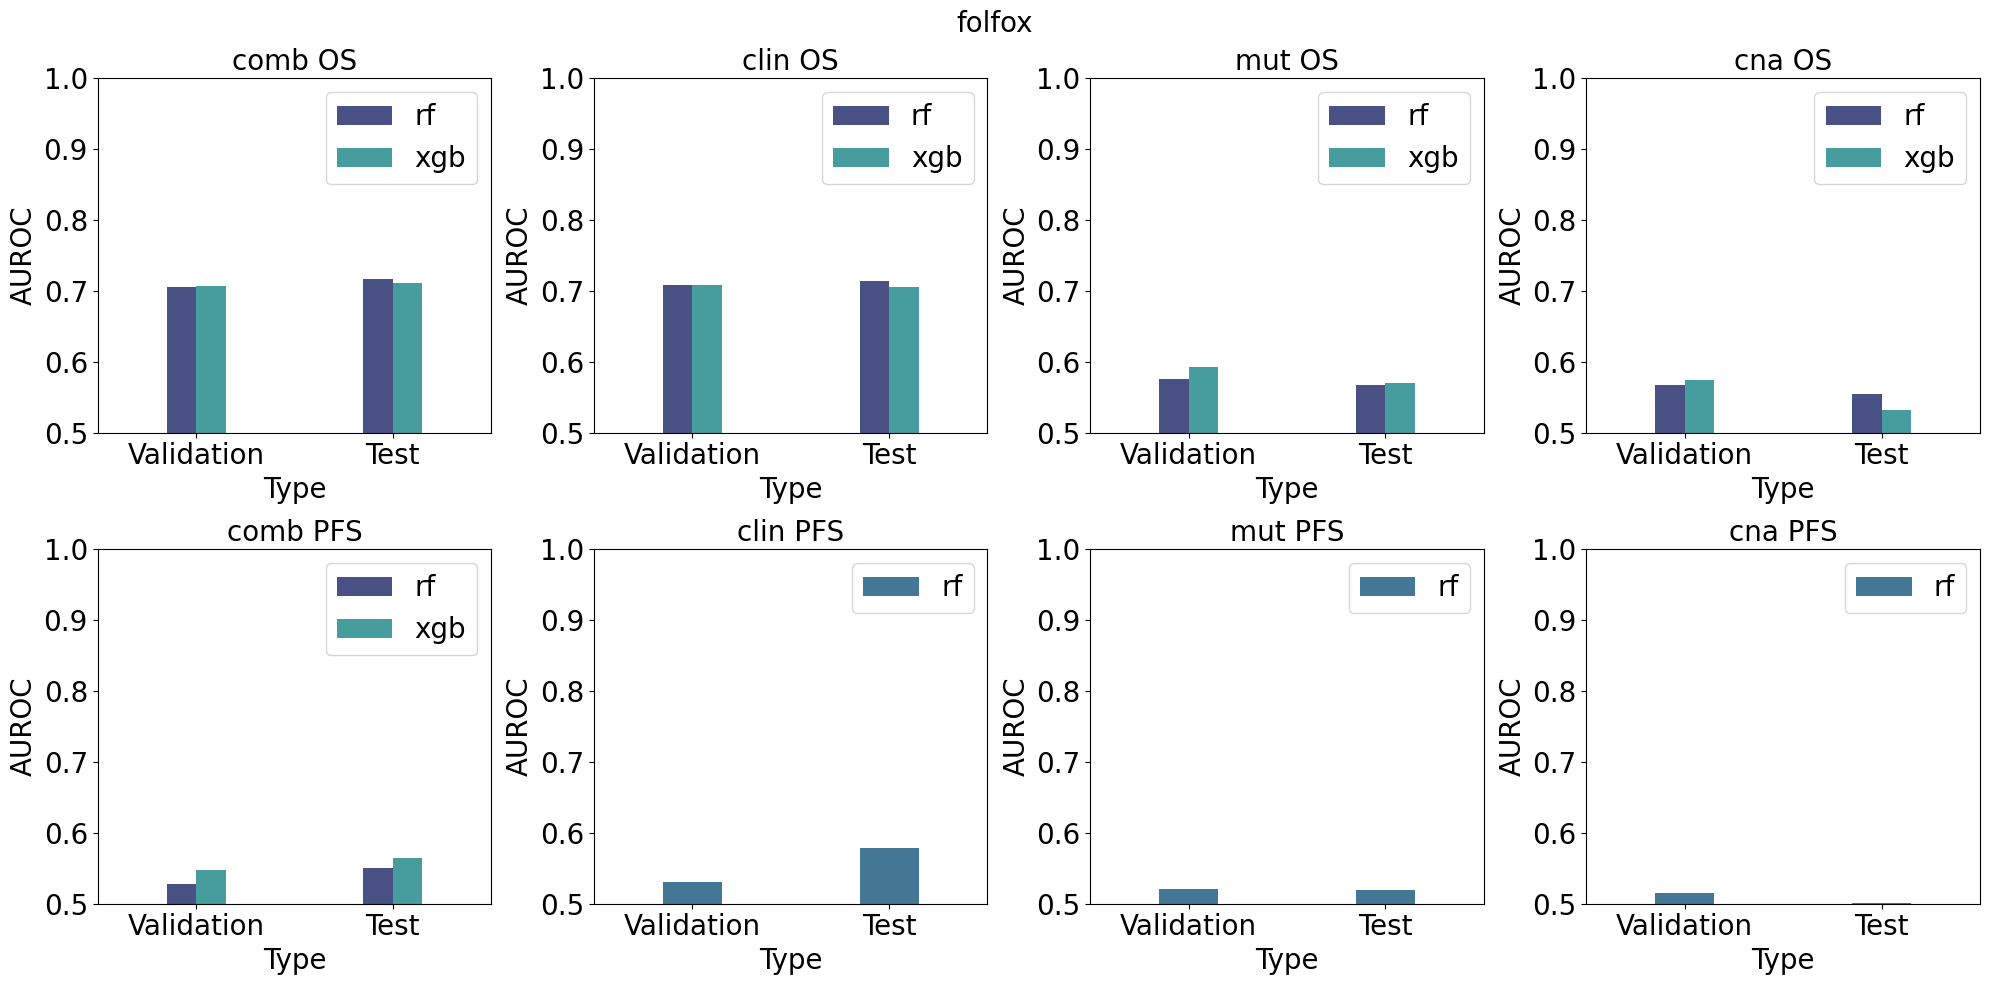

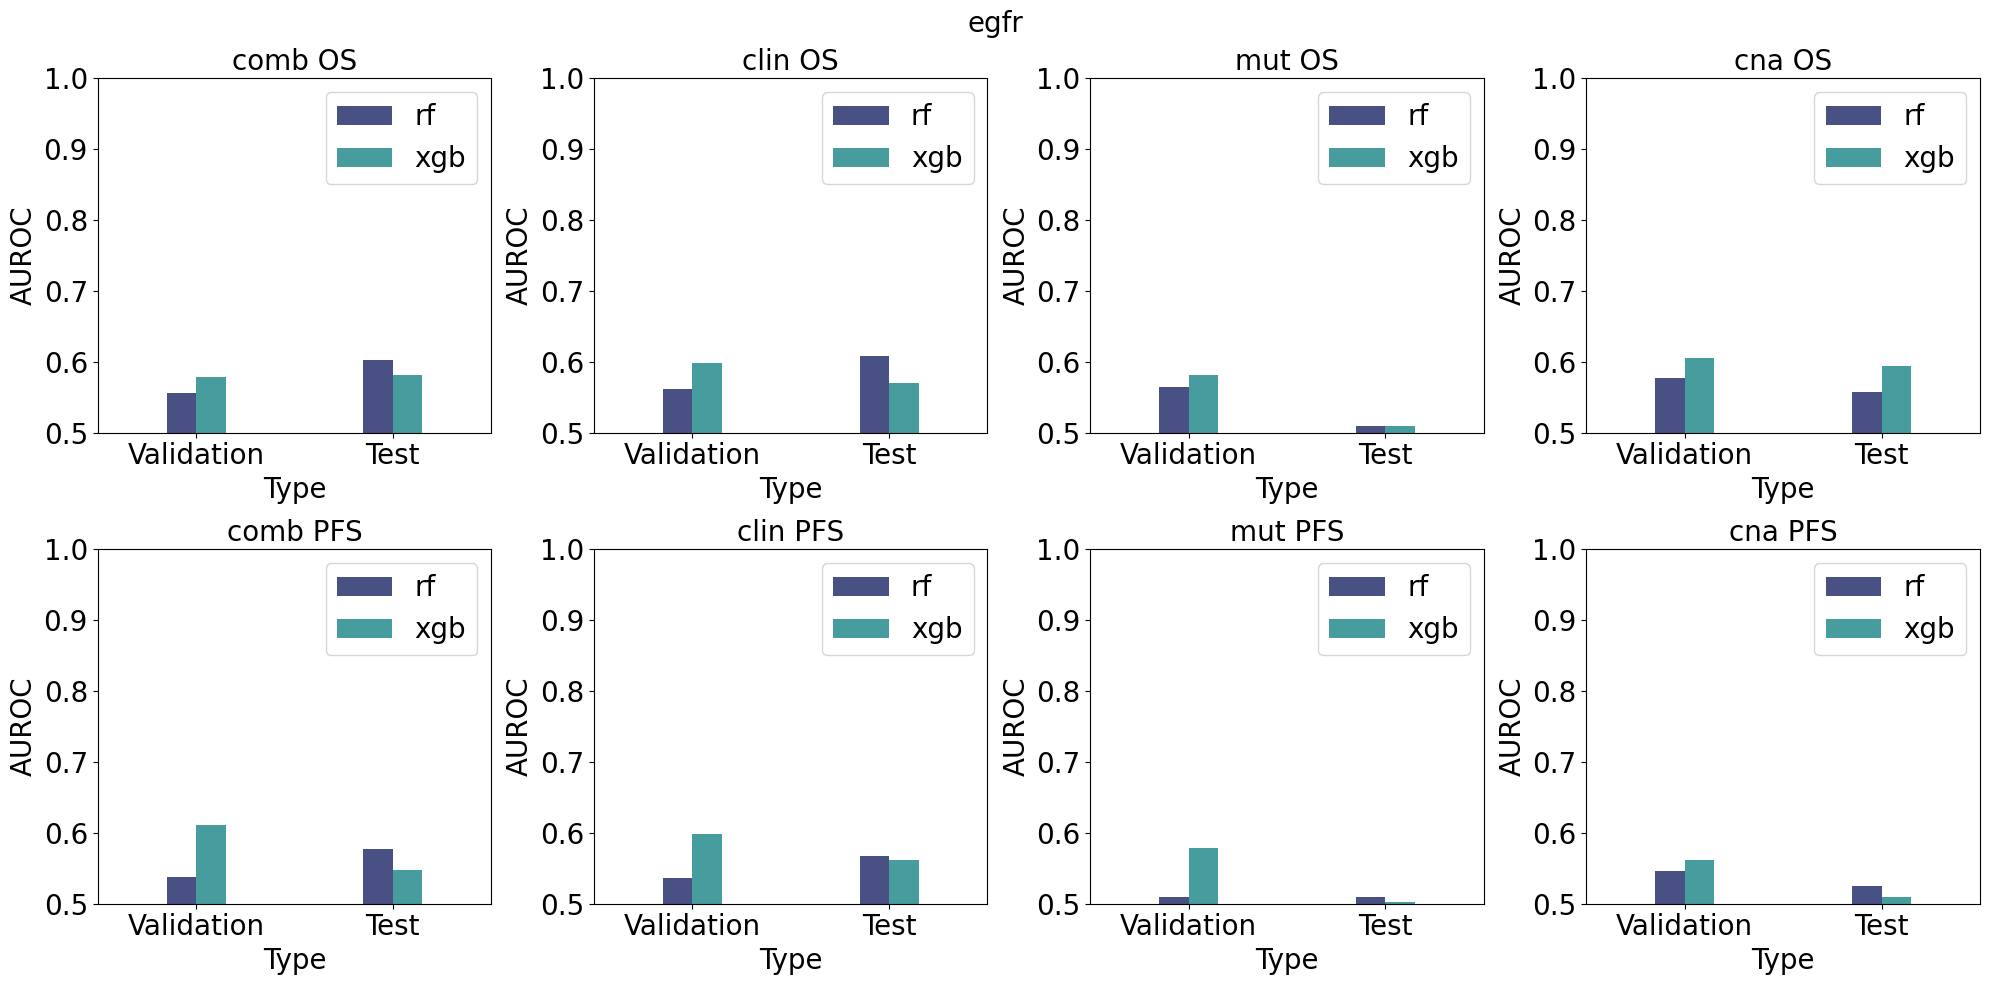

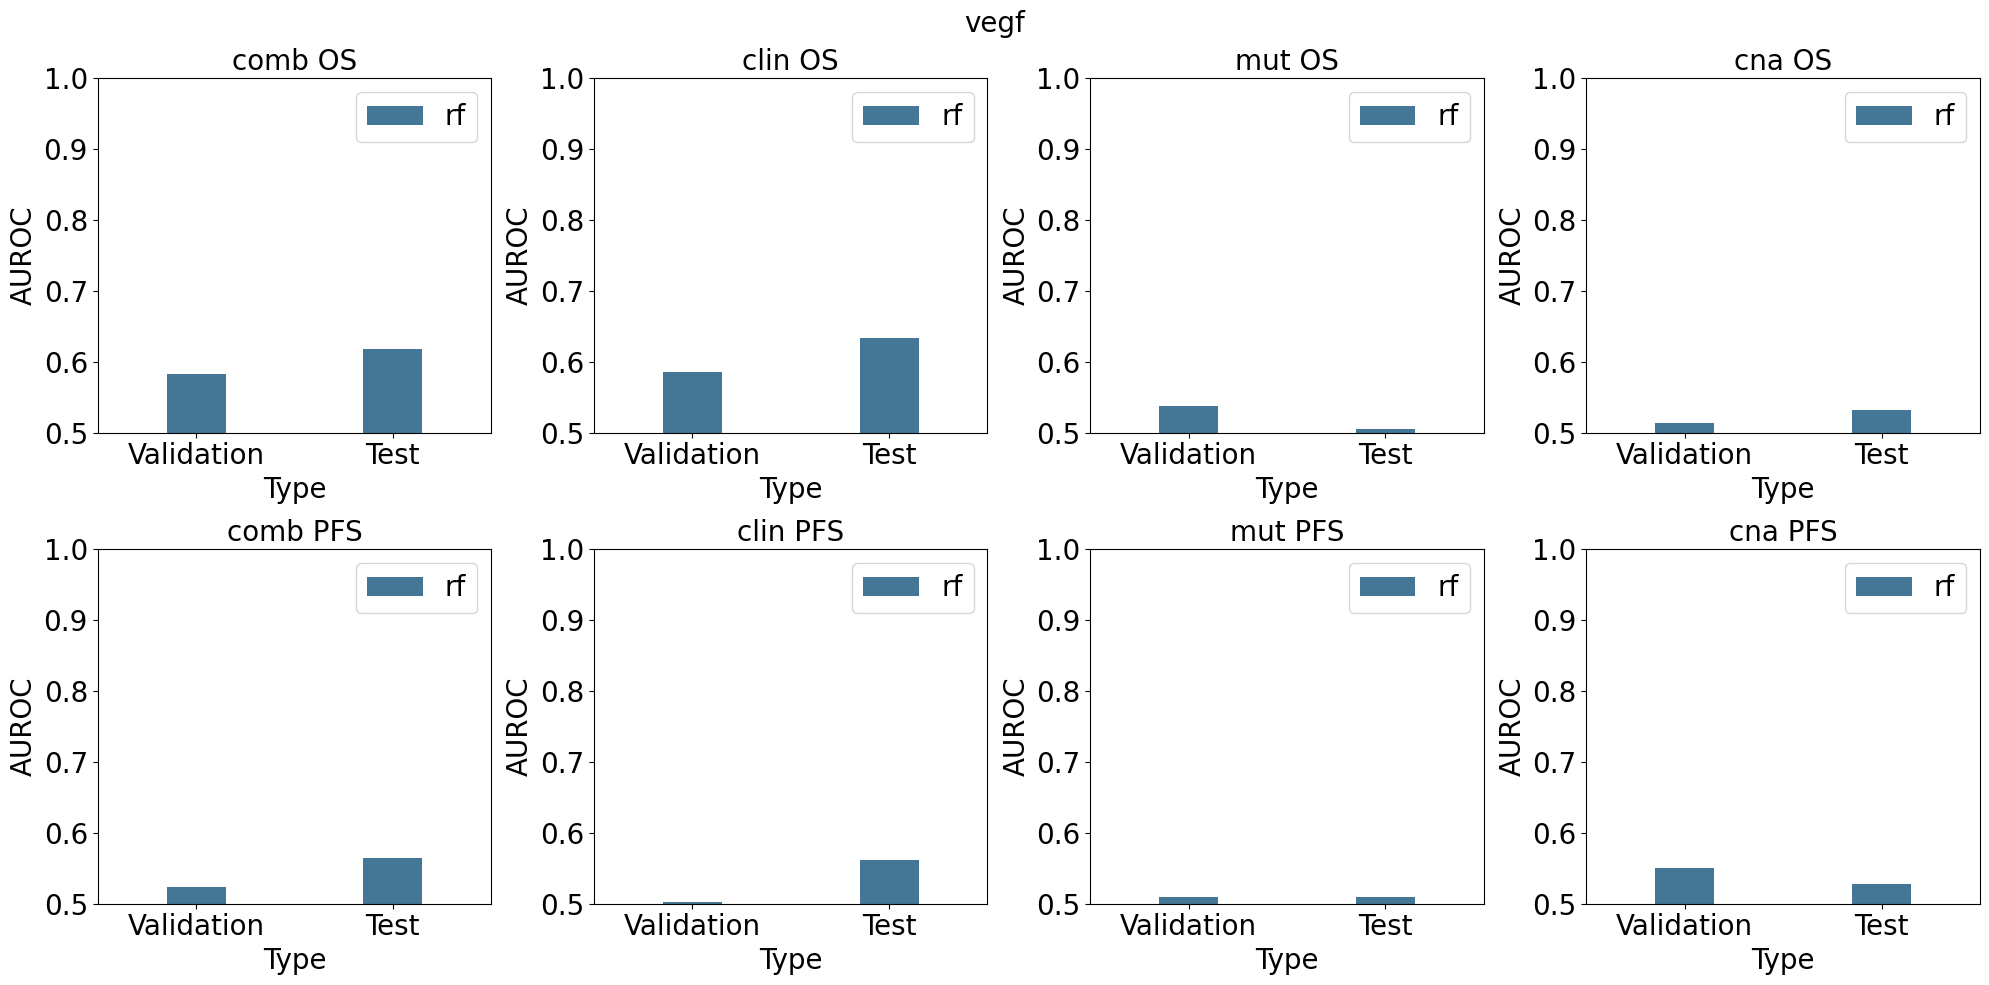

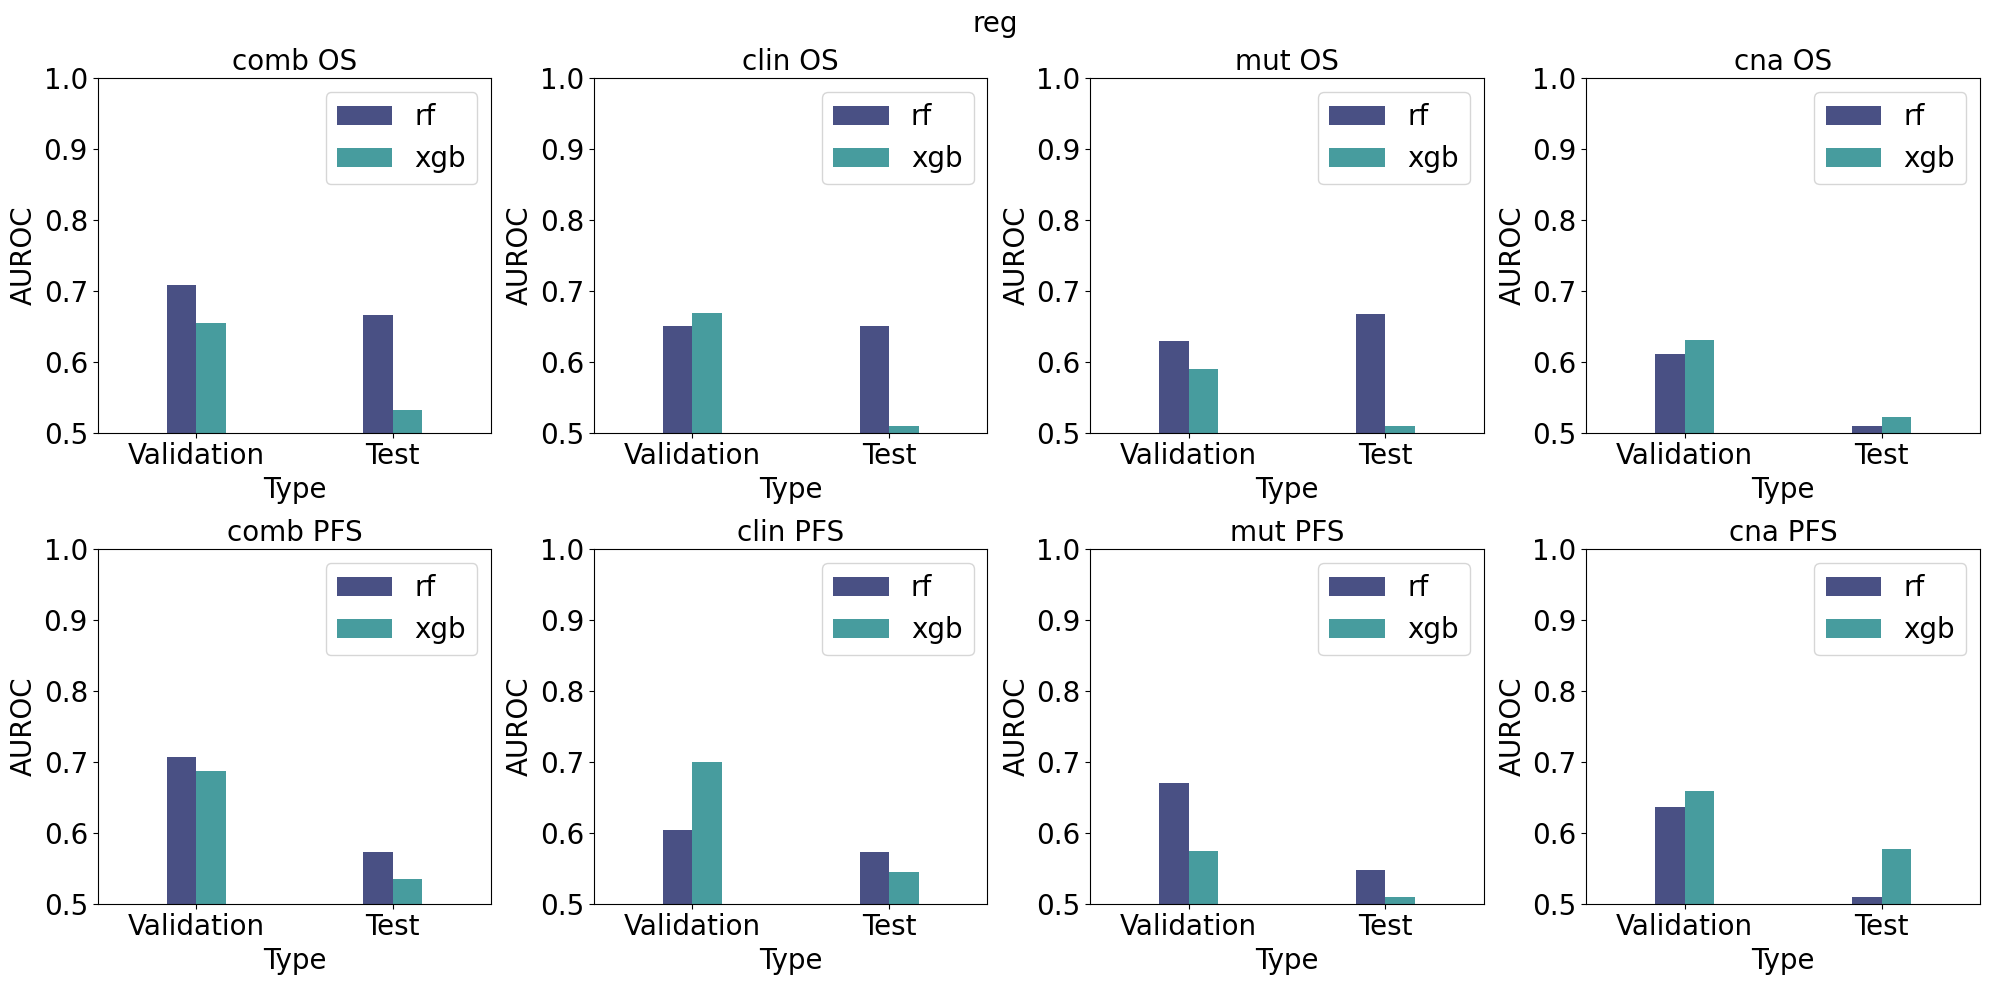

In [54]:
#for each drug, plot the results as a bar graph in a 2x4 grid, where each row is a different outcome and each column is a different data type
for drug in drugs:
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(drug, fontsize=20)
    for i, dtype_outcome in enumerate(dtype_outcomes):
        dtype = dtype_outcome[1]
        outcome = dtype_outcome[0]
        #keep OS on the first row and PFS on the second row, and order the dtypes as comb, clin, mut, cna
        i = dtype_outcomes_dict[str(outcome) + '_' + str(dtype)]
        res_data = res_dfs[str(drug) + '_' + str(outcome)][res_dfs[str(drug) + '_' + str(outcome)]['data_type'] == dtype]
        res_data = res_data[['model', 'val_auroc_mean', 'test_auroc_mean']]
        res_data.columns = ['Model', 'Validation', 'Test']
        res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
        ax = ax.flatten()
        res_data.sort_values(by='Model', inplace=True)
        #if the value is < 0.5, set it to 0.51
        res_data['AUROC'] = res_data['AUROC'].apply(lambda x: 0.51 if x < 0.5 else x)
        sns.barplot(x='Type', y='AUROC', hue='Model', data=res_data, errorbar=None, ax=ax[i], palette='mako', width=0.3)
        ax[i].set_ylim(0.5, 1)
        ax[i].set_title(dtype + ' ' + outcome, fontsize=20)
        for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] + ax[i].get_xticklabels() + ax[i].get_yticklabels()):
            item.set_fontsize(20)
        ax[i].legend(fontsize=20)
    plt.tight_layout()
    if not os.path.exists(f'../results/figures/runs/{today_str}'):
        os.makedirs(f'../results/figures/runs/{today_str}')
    plt.savefig(f'../results/figures/runs/{today_str}/{drug}_results.png')